In [208]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns
from sklearn.model_selection import KFold
from joblib import dump, load
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15.7,15)})

%matplotlib inline

In [371]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [238]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 2
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

In [210]:
df = pd.read_csv(r'NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [211]:
df.shape

(120000, 8)

In [212]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [213]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [214]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


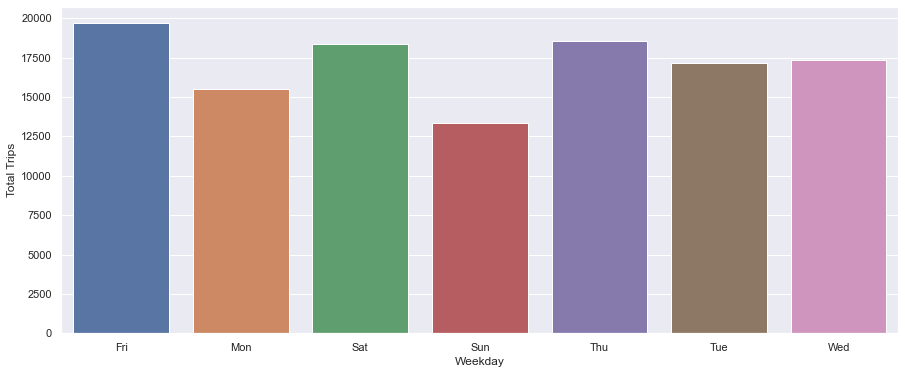

In [322]:
agg_df = df.groupby('Weekday')['pickup_datetime'].count()
agg_df = agg_df.reset_index()
agg_df.columns = ['Weekday','Total Trips']
plt.figure(figsize=(15,6))
sns.barplot(x=agg_df.Weekday, y=agg_df['Total Trips'])

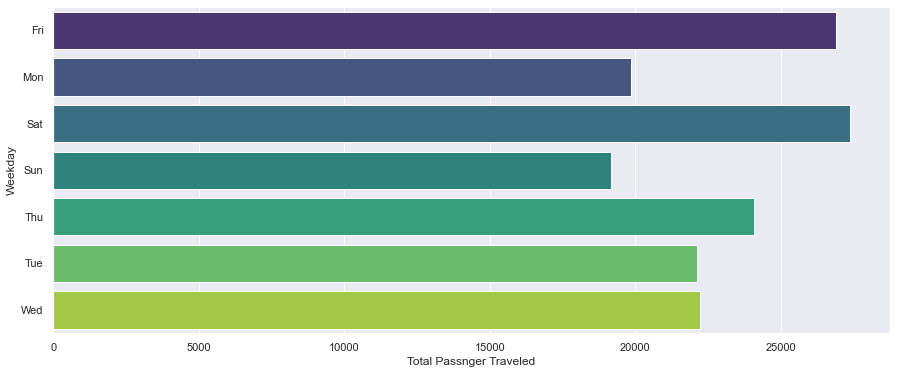

In [341]:
agg_psngr_df = df.groupby('Weekday')['passenger_count'].sum()
agg_psngr_df = agg_psngr_df.reset_index()
agg_psngr_df.columns = ['Weekday','Total Passnger Traveled']
plt.figure(figsize=(15,6))
sns.barplot(y=agg_psngr_df.Weekday, x=agg_psngr_df['Total Passnger Traveled'],palette="viridis")

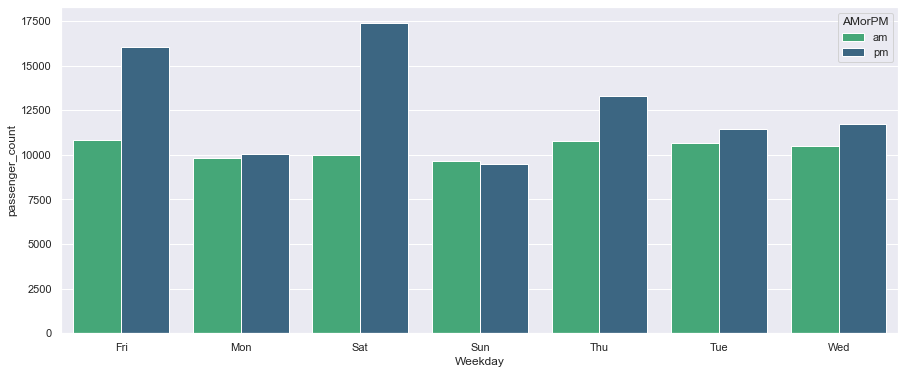

In [340]:
agg_daynight_df = df.groupby(['AMorPM','Weekday'])['passenger_count'].sum()
agg_daynight_df = agg_daynight_df.reset_index()
plt.figure(figsize=(15,6))
sns.barplot(x=agg_daynight_df.Weekday, y=agg_daynight_df['passenger_count'], hue=agg_daynight_df['AMorPM'], palette="viridis_r")

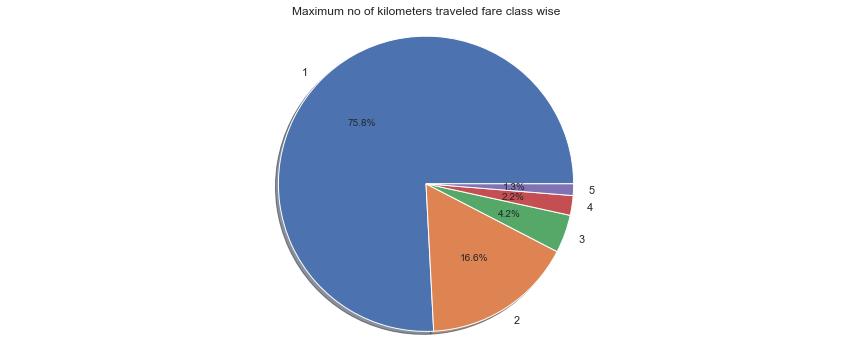

In [369]:
agg_dist_df = df.groupby(['passenger_count',])['dist_km'].sum()
agg_dist_df = agg_dist_df.reset_index()
fig1, ax1 = plt.subplots(figsize=(15,6))
ax1.pie(agg_dist_df['dist_km'], labels=agg_dist_df['passenger_count'], autopct='%3.1f%%', shadow=True)
ax1.axis('equal')
plt.title('Maximum no of kilometers traveled fare class wise')
plt.show()

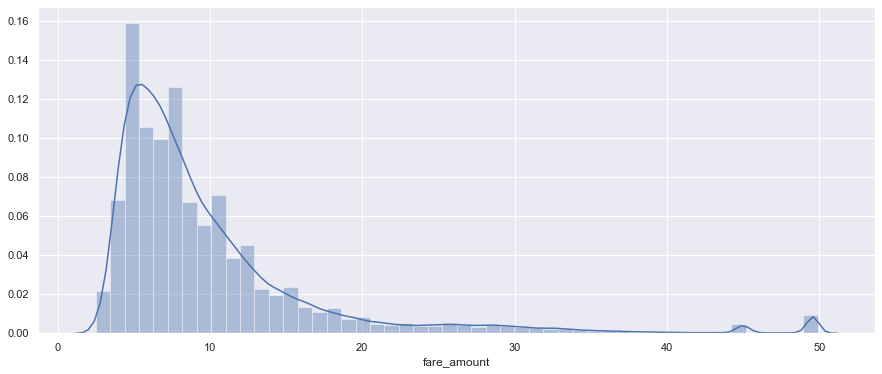

In [215]:
plt.figure(figsize=(15,6))
sns.distplot(df['fare_amount'])

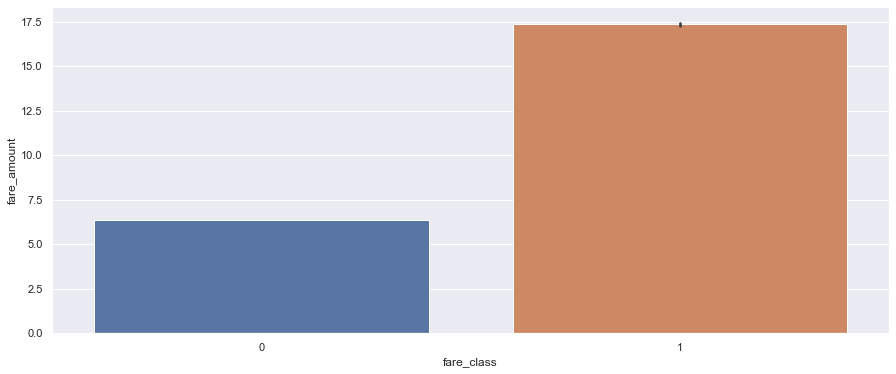

In [216]:
plt.figure(figsize=(15,6))
sns.barplot(x=df['fare_class'], y=df['fare_amount'])

In [227]:
emb_cols = ['Hour', 'AMorPM', 'Weekday']
cat_cols = ['hr', 'ampm', 'wkdy']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # this column contains the labels

In [225]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [220]:
df['hr'] = df['Hour'].cat.codes.values
df['ampm'] = df['AMorPM'].cat.codes.values
df['wkdy'] = df['Weekday'].cat.codes.values

In [229]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in emb_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [370]:
x_train, x_test, y_train, y_test = train_test_split(df[cat_cols+cont_cols], df[y_col], test_size=0.2, random_state=42, shuffle=True)

In [231]:
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

In [232]:
x_train.shape

(96000, 9)

In [233]:
x_test.shape

(24000, 9)

In [255]:
class AverageMeter:

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [256]:
class NYC_Train_Dataset:
    def __init__(self, features, targets):
        self.cat = features[cat_cols]
        self.cont = features[cont_cols]
        self.targets = targets
        self.features = features
        
    def __len__(self):
        return (self.features[cat_cols+cont_cols].shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x_cat' : torch.tensor(self.cat.iloc[idx, :], dtype=torch.long),
            'x_cont' : torch.tensor(self.cont.iloc[idx, :], dtype=torch.float),
            'target' : torch.tensor(self.targets.iloc[idx, :], dtype=torch.float)            
        }
        return dct
    
class NYC_Test_Dataset:
    def __init__(self, features):
        self.cat = features[cat_cols]
        self.cont = features[cont_cols]
        self.features = features
        
    def __len__(self):
        return (self.features[cat_cols+cont_cols].shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x_cat' : torch.tensor(self.cat.iloc[idx, :], dtype=torch.long),
            'x_cont' : torch.tensor(self.cont.iloc[idx, :], dtype=torch.float),
        }
        return dct
    

In [272]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    losses = AverageMeter()
    tk0 = tqdm(dataloader, total = len(dataloader))
    for b_idx, data in enumerate(tk0):
        optimizer.zero_grad()
        category, continous, targets = data['x_cat'].to(device), data['x_cont'].to(device), data['target'].to(device)
        outputs = model(category, continous)
        loss = torch.sqrt(loss_fn(outputs, targets))
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.update(loss.item(), dataloader.batch_size)
        tk0.set_postfix(loss=losses.avg)
    tk0.close() 
    return losses.avg


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    losses = AverageMeter()
    valid_preds = []  
    with torch.no_grad():
        tk0 = tqdm(dataloader, total = len(dataloader))
        for b_idx, data in enumerate(tk0):
            category, continous, targets = data['x_cat'].to(device), data['x_cont'].to(device), data['target'].to(device)
            outputs = model(category, continous)
            loss = torch.sqrt(loss_fn(outputs, targets))
            losses.update(loss.item(), dataloader.batch_size)
            tk0.set_postfix(loss=losses.avg)
            valid_preds.append(outputs.detach().cpu().numpy())
        valid_preds = np.concatenate(valid_preds)
        tk0.close()
    return losses.avg, valid_preds


def inference_fn(model, dataloader, device):
    model.eval()
    preds = []   
    tk0 = tqdm(dataloader, total=len(dataloader))
    for data in tk0:
        category, continous = data['x_cat'].to(device), data['x_cont'].to(device)
        with torch.no_grad():
            outputs = model(category, continous)
        preds.append(outputs.detach().cpu().numpy())
    preds = np.concatenate(preds)
    
    return preds

In [273]:
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, n_cat, num_targets, hidden_size, p=0.3):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        self.batch_norm1 = nn.BatchNorm1d(n_in)
        self.dense1 = nn.Linear(n_in, hidden_size)
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.3)
        self.dense2 = nn.Linear(hidden_size, hidden_size)
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.3)
        self.dense3 = nn.Linear(hidden_size, num_targets)

    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x) 
        return x

In [288]:
def run_training(x_train, x_test, y_train, y_test):

    train_dataset = NYC_Train_Dataset(x_train, y_train)
    valid_dataset = NYC_Train_Dataset(x_test, y_test)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = TabularModel(
        emb_szs = emb_szs, 
        n_cont = x_train[cont_cols].shape[1], 
        n_cat = x_train[cat_cols].shape[1], 
        num_targets =1, 
        hidden_size =512, 
        p=0.5
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.MSELoss()    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
   
    oof = np.zeros((len(x_test), 1))
    best_loss = np.inf     
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_fn, trainloader, DEVICE)
        print(f"EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"EPOCH: {epoch}, valid_loss: {valid_loss}")
        if valid_loss < best_loss:
            
            oof +=preds
            best_loss = valid_loss
            torch.save(model.state_dict(), f"NYC.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
    return oof     

In [289]:
valid_preds = run_training(x_train, x_test, y_train, y_test)


  1%|▍                                                                      | 2/375 [00:00<00:26, 14.32it/s, loss=4.22]

EPOCH: 0, train_loss: 4.175088906049728


  0%|                                                                              | 0/1500 [00:00<?, ?it/s, loss=6.68]

EPOCH: 0, valid_loss: 2.817834473609924


  1%|▍                                                                       | 2/375 [00:00<00:25, 14.64it/s, loss=4.8]

EPOCH: 1, train_loss: 3.1905566109816235


100%|█████████████████████████████████████████████████████████████████████| 375/375 [00:25<00:00, 14.51it/s, loss=2.66]

EPOCH: 1, valid_loss: 2.663698527654012


In [298]:
def predict(x):   
    testdataset = TestDataset(x)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = TabularModel(
        emb_szs = emb_szs, 
        n_cont = x_test[cont_cols].shape[1], 
        n_cat = x_test[cat_cols].shape[1], 
        num_targets =1, 
        hidden_size =512, 
        p=0.5
    )
    
    model.load_state_dict(torch.load(f"NYC.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(x_test), 1))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return predictions


In [299]:
pred = predict(x_test)

100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:21<00:00, 17.45it/s]


In [296]:
from sklearn.metrics import mean_squared_error, r2_score
np.sqrt(mean_squared_error(y_test, valid_preds/2))

2.9827609613981023

In [372]:
r2_score(y_test, predictions)

0.8422801915400682